[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucashofer/atomcloud/blob/main/docs/notebooks/Multi_Functions.ipynb)

# AtomCloud Multi-Functions

An AtomCloud Multi function object allow us to construct a single function out of individual subfunctions. This is needed when we use either SciPy or JAXFit to do curve fitting on data.

First, let's install AtomCloud and JAXFit (for GPU acceleration).

In [ ]:
!pip install jaxfit
!pip install atomcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 13.9 MB/s eta 0:00:00


## 1D Multi-Function

 Let's start out with the 1D case. By default atomcloud has six 1d functions to choose from (although you can add your own). The functions defined are all related to common distributions found in cold atom physics they are: "gaussian", "ebose", "febose", "parabola", "tf" and "foffset". Ebose stands for the enhanced Bose-Einstein distribution and febose stands for fixed enhanced Bose-Einstein distribution---where the fugacity is fixed to 1. The parabola and tf functions are the parabola and Thomas-Fermi distributions respectively (where the Thomas-Fermi distribution has been integrated along two of the three dimensions). Finally, the foffset refers to a fixed offset function. This is a function that is a constant offset from zero. This is useful for fitting data that has a constant background.

We can combine these functions into a single function using the MultiFunction object. Let's start by creating a multi function object with the "gaussian", "parabola" and "foffset" functions. First we create our independent data.

In [ ]:
import numpy as np

data_length = 256
x = np.linspace(0, data_length - 1, data_length)

Next we create a list of parameters for each function

In [ ]:

gaussian_n0 = 1.2
gaussian_x0 = data_length * (1 / 4)
gaussian_std = 10
parabola_n0 = 1.5
parabola_x0 = data_length * (3 / 4)
parabola_r = 15

gaussian_params = [gaussian_n0, gaussian_std, gaussian_x0]
parabola_params = [parabola_n0, parabola_r, parabola_x0]
offset_params = [0.3]

Now we import the 1d MultiFunction object and create our function. To instantiate the MultiFunction object we need to pass it the list of functions as as string. We can optionally pass it a list of parameters to constrain, but we'll address this later.

Once instantiated, the object can be used as a function. We can pass it our independent data and the function parameters as a list of the individual function parameters' lists.

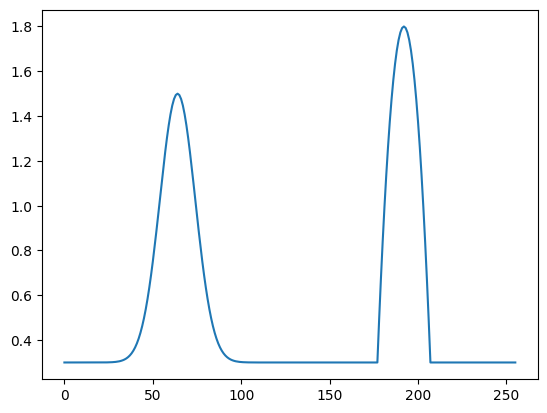

In [ ]:
import matplotlib.pyplot as plt
from atomcloud.functions import MultiFunction1D

bimodal_equations = ['gaussian', 'parabola', 'foffset']
bimodal_parameters = [gaussian_params, parabola_params, offset_params]

bimodal_func = MultiFunction1D(bimodal_equations)
bimodal_data = bimodal_func(x, bimodal_parameters)

plt.figure()
plt.plot(x, bimodal_data)

When fitting, we often wish for two or more parameters to be constrained to be equal. For example, we may want the translation of the parabola and the offset of the gaussian to be equal.

We can do this by passing a list of parameter constraints when instantiating the multifunction object. When constraining a parameter variable, the variable will technically be defined twice (once in each function parameter list). In this case, the multifunction object will use the first definition of the variable (i.e. the first function parameter list where it is defined).

We'll do this on the above example by constraining the "x0" parameter between the two functions.

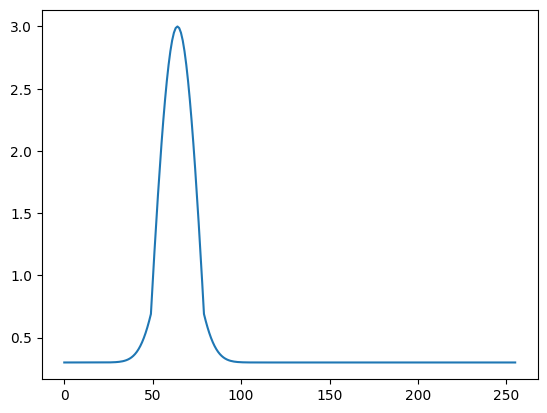

In [ ]:
bimodal_constraints = ['x0']

bimodal_func = MultiFunction1D(bimodal_equations, bimodal_constraints)
bimodal_data = bimodal_func(x, bimodal_parameters)

plt.figure()
plt.plot(x, bimodal_data)

Finally, we can JAX rather than Numpy to create these multifunctions by passing in a flag. This creates multifunctions that are compatible with JAXFit and allow blazing fast fitting.

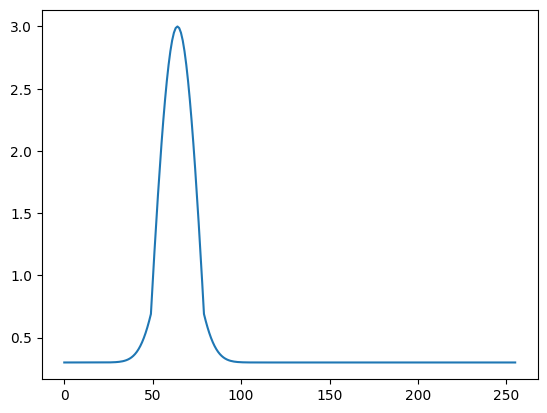

In [ ]:
bimodal_func = MultiFunction1D(bimodal_equations,
                               bimodal_constraints,
                               use_jax=True)

bimodal_data = bimodal_func(x, bimodal_parameters)

plt.figure()
plt.plot(x, bimodal_data)

## Defining Custom Sub-Functions

By default, only 'gaussian', 'parabola', 'tf', 'ebose' 'febose' and 'foffset' are defined. However, this is a fairly limited number of functions and we might wish to add our own.

All of the function objects are defined in the 1d and 2d function registries. They all inherit from the common FunctionBase class. This means we can easily create our own function objects from this class and add them to the registry.

In [ ]:
from atomcloud.functions import FunctionBase, FUNCTIONS1D
from atomcloud.analysis import rescale_1d_params


class Cos1D(FunctionBase):
    """See FunctionBase for documentation"""

    def __init__(self):
        super().__init__()

    def create_function(self, anp):
        def exp_func(x, a, b, x0):
            return a * anp.cos(b * (x - x0))
        return exp_func

FUNCTIONS1D.register('cos', Cos1D)

And now we can use this new function in our multifunction object.

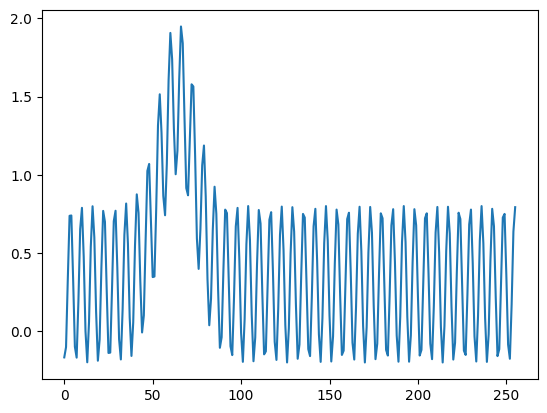

In [ ]:
from atomcloud.functions import MultiFunction1D

cos_x0 = data_length * (3 / 4)
cos_amp = .5
cos_freq = 1

cos_params = [cos_amp, cos_freq, cos_x0]
all_params = [gaussian_params, cos_params, offset_params]

cos_equations = ['gaussian', 'cos', 'foffset']
cos_func = MultiFunction1D(cos_equations)
cos_data = cos_func(x, all_params)

plt.figure()
plt.plot(x, cos_data)
plt.show()

In reality, there's more class functions we should define if we want to use this function for fitting. Below we show a more complete example of a custom function object. Many of the additional functions are used to define default parameters for fitting including seed and bound values. Additionally, we can define rescaling functions which are used later in analysis. We refer the reader to the docs as this is a more advanced topic.

## 2D MultiFunctions

We can also do this for 2D functions. Below we use a fixed enhanced bose (fugacity=1), a thomas-fermi profile and a fixed offset

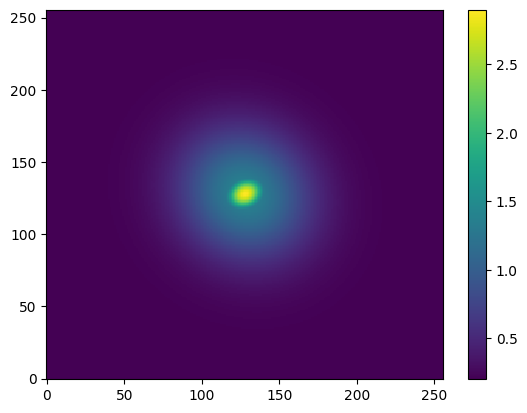

In [ ]:
from atomcloud.functions import MultiFunction2D

coords = np.meshgrid(x, x)

#common parameters
x0 = data_length / 2
y0 = x0
theta = np.pi / 3

#subfunction parameters
gaussian_stdx = 31.2
gaussian_stdy = 28
tf_rx = 10.4
tf_ry = 13.1
offset = 0.2

gaussan_params = [1.2, x0, y0, gaussian_stdx, gaussian_stdy, theta]
tf_params = [1.5, x0, y0, tf_rx, tf_ry, theta]
offset_params = [offset]

bimodal_equations = ['gaussian', 'tf', 'foffset']
bimodal_parameters = [gaussan_params, tf_params, offset_params]
bimodal_constraints = ['x0', 'y0']

bimodal_func = MultiFunction2D(bimodal_equations,
                               bimodal_constraints,
                               use_jax=True)

bimodal_data = bimodal_func(coords, bimodal_parameters)

plt.figure()
plt.pcolormesh(*coords, bimodal_data)
plt.colorbar()
plt.show()

Now we'll creat a custom 2D funtion and add it to the 2D function register. In contrast to the 1D function, we'll include some of the additional object functions such as initial seed and default bounds.

In [ ]:
from atomcloud.functions import FunctionBase, FUNCTIONS2D
from atomcloud.analysis import rescale_2d_params

class Sin2D(FunctionBase):
    """See FunctionBase for documentation"""

    def __init__(self):
        super().__init__()

    def create_function(self, anp):
        def a_sin_func(coords, a, b, c):
            x, y = coords
            return a * np.sin(b * x + c * y)
        return a_sin_func

    def initial_seed(self, x, data):
        min_ind = np.argmin(data)
        max_ind = np.argmax(data)
        a = (data[max_ind] - data[min_ind]) / 2
        xdelta = x[-1] - x[0]
        b = xdelta / 10
        c = xdelta / 12
        return [a, b, x0]

    def rescale_parameters(self, params, scale):
        _, axis_scale, zscale = scale
        zinds = [0]
        xinds = [1, 2]
        return rescale_2d_params(params, zinds, xinds, axis_scale, zscale)

    def default_bounds(self):
        min_bounds = [0, 0, -np.inf]
        max_bounds = [np.inf, np.inf, np.inf]
        return [min_bounds, max_bounds]

FUNCTIONS2D.register('sin', Sin2D)

Now let's use it!

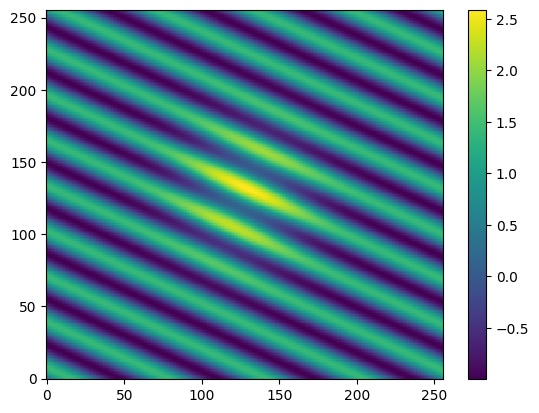

In [ ]:
sin_freq_x = .1
sin_freq_y = .2
sin_amp = 1.2

sin_params = [sin_amp, sin_freq_x, sin_freq_y]
all_params = [gaussan_params, sin_params, offset_params]

sin_equations = ['gaussian', 'sin', 'foffset']
sin_func = MultiFunction2D(sin_equations)
sin_data = sin_func(coords, all_params)

plt.figure()
plt.pcolormesh(*coords, sin_data)
plt.colorbar()
plt.show()

This all seems fairly simple, but the being able to build arbitrary multifunctions from the registry objects means we can do some pretty powerful things later with both fitting and analysis of our fits.